In [1]:
import pandas as pd
import numpy as np
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os.path
from os import path
from sklearn.model_selection import KFold

# 1° Load data

In [5]:
data = pd.read_csv("Data/miniloan-decisions-100K.csv")

In [6]:
data

,name,creditScore,income,loanAmount,monthDuration,rate,approval,yearlyReimbursement
0,John Doe,736,113243,783440,162,0.030005,false,70648
1,John Doe,527,224186,1787385,183,0.054819,false,173197
2,John Doe,460,39954,1733494,75,0.055183,false,328563
3,John Doe,751,219998,1350004,72,0.043400,false,255970
4,John Doe,684,72470,1210944,160,0.037772,false,115742
...,...,...,...,...,...,...,...,...
99995,John Doe,366,83851,1718571,168,0.053737,false,174928
99996,John Doe,395,184259,1599473,90,0.040564,false,247703
99997,John Doe,674,242620,1099790,260,0.040825,false,76557
99998,John Doe,420,180957,1645870,203,0.049558,false,143897


# Ratios

In [7]:
#['name', 'creditScore', 'income', 'loanAmount', 'monthDuration', 'rate', 'approval', 'yearlyReimbursement']

ratioNames = [("income","yearlyReimbursement"), ("income","loanAmount"), ("loanAmount","rate")]

In [8]:
def createFeaturesRatio(data):
    if data[data.index[1]] == 0:
        return 2147483647
    return np.round(data[data.index[0]]/data[data.index[1]], decimals=2)

In [9]:
for ratioName in ratioNames:
    data[f"{ratioName[0]}/{ratioName[1]}"] = data[[ratioName[0], ratioName[1]]].apply(createFeaturesRatio, axis=1)

In [10]:
data

,name,creditScore,income,loanAmount,monthDuration,rate,approval,yearlyReimbursement,income/yearlyReimbursement,income/loanAmount,loanAmount/rate
0,John Doe,736,113243,783440,162,0.030005,false,70648,1.60,0.14,26110372.80
1,John Doe,527,224186,1787385,183,0.054819,false,173197,1.29,0.13,32605003.59
2,John Doe,460,39954,1733494,75,0.055183,false,328563,0.12,0.02,31413368.70
3,John Doe,751,219998,1350004,72,0.043400,false,255970,0.86,0.16,31106073.81
4,John Doe,684,72470,1210944,160,0.037772,false,115742,0.63,0.06,32059172.14
...,...,...,...,...,...,...,...,...,...,...,...
99995,John Doe,366,83851,1718571,168,0.053737,false,174928,0.48,0.05,31981153.44
99996,John Doe,395,184259,1599473,90,0.040564,false,247703,0.74,0.12,39430859.20
99997,John Doe,674,242620,1099790,260,0.040825,false,76557,3.17,0.22,26938940.88
99998,John Doe,420,180957,1645870,203,0.049558,false,143897,1.26,0.11,33211031.24


# 2° Create the thresholds

In [11]:
thresholds = np.arange(0.25,1,0.25)
thresholds_str = ["-"+(str(int(i*100))) for i in thresholds]

In [12]:
def fromColumnToColumnPercent(name, percents):
    res = []
    for i in percents:
        res.extend([name[0]+i]*(len(percents)**(len(name)-1))) 
    return res

In [13]:
def descriptionDiffThresholds(data, percents):
    thresholds_Dic =  {}
    for column in data.columns:
        serie = data[column]
        thresholds_Dic[column] = serie.quantile(percents)
        
    return pd.DataFrame.from_dict(thresholds_Dic)

In [14]:
# columnsGreaterBetter = ['creditScore', 'income', 'rate', 'monthDuration']
# columnsLowerBetter = ['loanAmount', 'yearlyReimbursement']

columnsToMix = ['creditScore', 'income', 'loanAmount', 'monthDuration', 'rate', 'yearlyReimbursement', 'income/yearlyReimbursement']

description = descriptionDiffThresholds(data[columnsToMix], thresholds)

mix = []

for i in range(len(columnsToMix)):
    for j in range(i+1,len(columnsToMix)):
        for k in range(j+1, len(columnsToMix)):
            mix.append((columnsToMix[i],columnsToMix[j],columnsToMix[k]))
        mix.append((columnsToMix[i],columnsToMix[j]))
    #mix.append((columnsToMix[i]))

In [15]:
def GTE_prep_df(value, valueToCompareTo):
    return value >= valueToCompareTo

def LTE_prep_df(value, valueToCompareTo):
    return value <= valueToCompareTo

In [16]:
%%time

booleanDF = pd.DataFrame()

for column in columnsToMix:
    for i, value in enumerate(thresholds):
        booleanDF[column+"-GTE-"+str(int(value*100))] = data[column].map(lambda x : GTE_prep_df(x, description[column].values[i]))
        booleanDF[column+"-LTE-"+str(int(value*100))] = data[column].map(lambda x : LTE_prep_df(x, description[column].values[i]))

CPU times: user 13.1 s, sys: 46.9 ms, total: 13.1 s
Wall time: 13.1 s


In [17]:
booleanDF["approval"] = data["approval"].map({' true': True, ' false': False})
booleanDF

,creditScore-GTE-25,creditScore-LTE-25,creditScore-GTE-50,creditScore-LTE-50,creditScore-GTE-75,creditScore-LTE-75,income-GTE-25,income-LTE-25,income-GTE-50,income-LTE-50,...,yearlyReimbursement-LTE-50,yearlyReimbursement-GTE-75,yearlyReimbursement-LTE-75,income/yearlyReimbursement-GTE-25,income/yearlyReimbursement-LTE-25,income/yearlyReimbursement-GTE-50,income/yearlyReimbursement-LTE-50,income/yearlyReimbursement-GTE-75,income/yearlyReimbursement-LTE-75,approval
0,True,False,True,False,True,False,True,False,False,True,...,True,False,True,True,False,True,False,False,True,False
1,True,False,False,True,False,True,True,False,True,False,...,False,True,False,True,False,False,True,False,True,False
2,True,False,False,True,False,True,False,True,False,True,...,False,True,False,False,True,False,True,False,True,False
3,True,False,True,False,True,False,True,False,True,False,...,False,True,False,True,False,False,True,False,True,False
4,True,False,True,False,False,True,False,True,False,True,...,False,False,True,True,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,False,True,False,True,False,True,True,False,False,True,...,False,True,False,False,True,False,True,False,True,False
99996,False,True,False,True,False,True,True,False,True,False,...,False,True,False,True,False,False,True,False,True,False
99997,True,False,True,False,False,True,True,False,True,False,...,True,False,True,True,False,True,False,True,False,False
99998,False,True,False,True,False,True,True,False,True,False,...,False,False,True,True,False,False,True,False,True,False


In [15]:
booleanDF.to_csv("./../dfSave.csv")

# 3° Save the best data

In [18]:
def intToStrIDS(idsInt):
    res = chr(97+idsInt%26)
    idsReducted = int(idsInt/26)
    while idsReducted != 0:
        res = chr(97+(idsReducted-1)%26) + res
        idsReducted = int(idsReducted/26)
    return res

def syntax(subject, predicate, objectD):
    return f"{subject}\t{predicate}\t{objectD} \n"#f"{intToStrIDS(subject)}\t{predicate}\t{objectD} \n"

def formatData(f, idData, data):
    toWrite = ""
    for i in data.index[:-1]:
        toWrite += syntax(idData, i, data.loc[i])
    if data.loc["approval"]:
        toWrite += syntax(idData, "approval-True", True)
    else:
        toWrite += syntax(idData, "approval-False", False)
    f.write(toWrite)

In [18]:
f = open("Knowledge_Data.tsv", "w")

booleanDF_to_Save = booleanDF
booleanDF_to_Save["approval"] = data["approval"].map({' true': True, ' false': False})

for idData in booleanDF_to_Save.index:
    formatData(f, idData, booleanDF_to_Save.iloc[idData])
    
f.close()

## Save in cross validation

In [23]:
import shutil

root = "./../data_cv/"
cv = 3

if not path.isdir(root):
    os.mkdir(root)
else : 
    shutil.rmtree(root)
    os.mkdir(root)
    
booleanDF_to_Save = booleanDF
booleanDF_to_Save["approval"] = data["approval"].map({' true': True, ' false': False})

kf = KFold(n_splits=cv, shuffle=True, random_state=42)
kf.get_n_splits(booleanDF_to_Save)

cp = 0

for train_index, test_index in kf.split(booleanDF_to_Save):
    
    f = open(root+f"CV_train_{cp}.tsv", "w")

    for idData in train_index:
        formatData(f, idData, booleanDF_to_Save.iloc[idData])

    f.close()
    
    print("Train repartition",booleanDF_to_Save.iloc[train_index]["approval"].value_counts())
    
    f = open(root+f"CV_valid_{cp}.tsv", "w")

    for idData in test_index:
        formatData(f, idData, booleanDF_to_Save.iloc[idData])

    f.close()
    
    f = open(root+f"index_{cp}.tsv", "w")

    f.write(str(train_index[0]))
    for i in range(1,len(train_index)):
        f.write(","+str(train_index[i]))
    f.write("\n")
    f.write(str(test_index[0]))
    for i in range(1,len(test_index)):
        f.write(","+str(test_index[i]))

    f.close()
    
    cp += 1

Train repartition False    52004
True     14662
Name: approval, dtype: int64
Train repartition False    52007
True     14660
Name: approval, dtype: int64
Train repartition False    52081
True     14586
Name: approval, dtype: int64


# 4° Launch Amie

In [24]:
root = "./../data_cv/"
cv = 3

In [25]:
class Atom:
    
    def __init__(self, atom_raw):
        self._subject = atom_raw[0][1:]
        self._predicate = atom_raw[1]
        self._objectD = atom_raw[2][1:]
        
    def __hash__(self):
        return hash((self._subject, self._predicate, self._objectD))
    
    def __repr__(self):
        return f"{self.subject} {self.predicate} {self.objectD}"
    
    def __eq__(self, other):
        return self.subject==other.subject and self.predicate==other.predicate and self.objectD==other.objectD
        
    @property
    def subject(self):
        return self._subject
    
    @property
    def predicate(self):
        return self._predicate
    
    @property
    def objectD(self):
        return self._objectD
    
class Rule:
    
    def __init__(self, hypotheses, conclusion):
        if not isinstance(hypotheses, tuple):
            self._hypotheses = tuple(hypotheses)
        else : 
            self._hypotheses = hypotheses
        self._conclusion = conclusion
        
    def __hash__(self):
        return hash((self._hypotheses, self._conclusion))
        
    def __repr__(self):
        toWrite=""
        for atom in self.hypotheses:
            toWrite += f"{atom} & "
        toWrite = toWrite[:-3] + " => " 
        toWrite += str(self.conclusion)
        return toWrite

    def __eq__(self, other):
        if not isinstance(other, Rule):
            return False
        return (self.conclusion == other.conclusion) and (set(self.hypotheses) == set(other.hypotheses))
    
    @property
    def hypotheses(self):
        return self._hypotheses
    
    @property
    def conclusion(self):
        return self._conclusion
            

In [4]:
%%capture captured

!java -jar amie3.jar -htr approval-True,approval-False Knowledge_Data.tsv

In [7]:
rules = []
for line in captured.stdout.split("\n"):
    if (line != "") and (line[0] == "?"):
        dic = {}
        parts = line.split("\t")
        
        
        conclusion_raw = parts[0].split("=>")[1].split("  ")
        conclusion_raw[0] = conclusion_raw[0][1:]
        dic["conclusion"] = Atom(conclusion_raw)
        
        hypotheses_raw = parts[0].split("=>")[0].split("  ")
        hypotheses = []
        for i in range(0, len(hypotheses_raw)-1, 3):
            hypotheses.append(Atom(hypotheses_raw[i:i+3]))
        dic["hypotheses"] = hypotheses
        
        
        rules.append(Rule(dic["hypotheses"], dic["conclusion"]))

In [27]:
%%capture captured

sep = "-----------------------------"

for i in range(cv):
    data = f"{root}CV_train_{i}.tsv"
    !java -jar amie3.jar -htr approval-True,approval-False $data
    print(sep)

In [130]:
captured.stdout

'Using the default schema relations\r\nAssuming rdf:type as type relation\r\nLoading files... \r\n  Starting CV_train_0.tsv\r\n  Finished CV_train_0.tsv, still running: 0\r\nLoaded 5120000 facts in 13.31 s using 3009 MB\r\nUsing HeadCoverage as pruning metric with minimum threshold 0.01\r\nUsing recursivity limit 3\r\nLazy mining assistant that stops counting when the denominator gets too high\r\nNo minimum threshold on standard confidence\r\nFiltering on PCA confidence with minimum threshold 0.1\r\nConstants in the arguments of relations are disabled\r\nLossless (query refinement) heuristics enabled\r\nMRT calls: 0\r\nStarting the mining phase... Using 16 threads\r\nRule\tHead Coverage\tStd Confidence\tPCA Confidence\tPositive Examples\tBody size\tPCA Body size\tFunctional variable\r\n?a  income/yearlyReimbursement-50  ?b   => ?a  approval-True  ?b\t1\t0.2197375\t1\t17579\t80000\t17579\t?a\r\n?a  income/yearlyReimbursement-70  ?b   => ?a  approval-True  ?b\t1\t0.2197375\t1\t17579\t800

In [28]:
rules_per_cv = []
for cv_res in captured.stdout.split(sep)[:-1]:
    rules = set()
    for line in cv_res.split("\n"):
        if (line != "") and (line[0] == "?"):
            dic = {}
            parts = line.split("\t")

            conclusion_raw = parts[0].split("=>")[1].split("  ")
            conclusion_raw[0] = conclusion_raw[0][1:]
            dic["conclusion"] = Atom(conclusion_raw)

            hypotheses_raw = parts[0].split("=>")[0].split("  ")
            hypotheses = []
            for i in range(0, len(hypotheses_raw)-1, 3):
                hypotheses.append(Atom(hypotheses_raw[i:i+3]))
            dic["hypotheses"] = hypotheses


            rules.add(Rule(dic["hypotheses"], dic["conclusion"]))
    rules_per_cv.append(rules)

In [29]:
score_ressemblance = []
for i in range(cv):
    for j in range(i+1, cv):
        score_ressemblance.append(len(rules_per_cv[i].intersection(rules_per_cv[j]))/len(rules_per_cv[i].union(rules_per_cv[j]))*100)
print(f"We have a mean of {np.round(np.mean(score_ressemblance),3)}")
print(f"We have a std of {np.round(np.std(score_ressemblance),3)}")

We have a mean of 92.255
We have a std of 1.625


# Prediction

In [30]:
def prediction_right(X, truth):
    if X["approval"] !=  truth:
        return "Not an example"
    else :
        sum_X = sum(X)
        return str(sum_X == len(X) or sum_X == 0)

In [31]:
def computeAccuracy(rules, df, acc_train, acc_test, rules_approval, index, cptShared):
    print(f"Process n°{index} : Launched")
    len_tot = len(rules)
    for cpt, rule in enumerate(rules):  
        columns = [rule.hypotheses[k].predicate for k in range(len(rule.hypotheses))]
        columns.append("approval")

        res = []

        if (rule.conclusion.predicate == "approval-True"):
            res = df[columns].loc[train_index].apply(func=prediction_right, axis=1, truth=True).value_counts()
        else :
            res = df[columns].loc[train_index].apply(func=prediction_right, axis=1, truth=False).value_counts()
            
        if not "False" in res.index:
            res["False"] = 0
            
        if not "True" in res.index:
            res["True"] = 0
            
        acc_train[str(rule)] = res["True"] / (res["True"]+res["False"])

        if (rule.conclusion.predicate == "approval-True"):
            res = df[columns].loc[test_index].apply(func=prediction_right, axis=1, truth=True).value_counts()
        else :
            res = df[columns].loc[test_index].apply(func=prediction_right, axis=1, truth=False).value_counts()
            
        if not "False" in res.index:
            res["False"] = 0
            
        if not "True" in res.index:
            res["True"] = 0

        acc_test[str(rule)] = res["True"] / (res["True"]+res["False"])
        
        rules_approval[str(rule)] = rule.conclusion.predicate == "approval-True"
        
        cptShared.value += 1
        if (cptShared.value%100 == 0):
            print(cptShared)
        
    print(f"Process n°{index} : Finished")

In [32]:
%%time

from multiprocessing import Process, Manager
import multiprocessing

names = []
accuracy_train_CV = []
accuracy_test_CV = []
rules_Approval_CV = []

for rules in rules_per_cv:
    with Manager() as manager:

        i = 0
        f = open(f"{root}index_{i}.tsv", "r")

        lines = f.readlines()
        train_index = np.array(list(map(int, lines[0].split(","))))
        test_index = np.array(list(map(int, lines[1].split(","))))

        f.close()

        df = pd.read_csv("./../dfSave.csv")

        acc_train =  manager.dict()
        acc_test =  manager.dict()
        rules_approval =  manager.dict()

        cpt_total = manager.Value("d",0)

        processes_to_create = multiprocessing.cpu_count()-3
        processes = list()

        rules_list = list(rules)

        for index in range(processes_to_create):
            x = Process(target=computeAccuracy, args=(rules_list[int(np.floor(index*len(rules_list)/processes_to_create)): int(np.floor((index+1)*len(rules_list)/processes_to_create))], df, acc_train, acc_test, rules_approval, index, cpt_total))
            processes.append(x)
            x.start()

        for index, process in enumerate(processes):
            process.join()

        accuracy_train_CV.append(acc_train.copy())
        accuracy_test_CV.append(acc_test.copy())
        rules_Approval_CV.append(rules_approval.copy())

    print(np.mean(list(accuracy_train_CV[0].values())))
    print(np.mean(list(accuracy_test_CV[0].values())))

Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched
Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched
Process n°7 : Launched
Process n°8 : Launched
Process n°9 : Launched
Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched
Value('d', 100)
Value('d', 200)
Value('d', 300)
Process n°5 : Finished
Process n°4 : Finished
Process n°2 : Finished
Process n°9 : Finished
Process n°0 : Finished
Process n°8 : Finished
Process n°12 : Finished
Process n°3 : Finished
Process n°1 : Finished
Process n°7 : Finished
Process n°10 : Finished
Process n°11 : Finished
Process n°6 : Finished
0.4984784339004878
0.4980473473262443
Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched
Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched
Process n°7 : Launched
Process n°8 : Launched
Process n°9 : Launched
Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched
Value('d

In [33]:
approval_DF = pd.DataFrame(rules_Approval_CV).describe().loc[["top"]].T.rename(columns={'top': 'Approval'})
approval_DF

,Approval
a income-LTE-75 b & a monthDuration-LTE-75 b => a approval-True b,True
a creditScore-LTE-75 b & a income-LTE-75 b => a approval-True b,True
a yearlyReimbursement-LTE-50 b => a approval-False b,False
a income-GTE-50 b & a rate-GTE-75 b => a approval-False b,False
a income-GTE-25 b & a monthDuration-LTE-75 b => a approval-True b,True
...,...
a creditScore-GTE-50 b & a loanAmount-LTE-25 b => a approval-True b,True
a creditScore-GTE-50 b & a income/yearlyReimbursement-LTE-25 b => a approval-False b,False
a creditScore-GTE-50 b & a income/yearlyReimbursement-GTE-50 b => a approval-False b,False
a creditScore-GTE-50 b & a yearlyReimbursement-LTE-25 b => a approval-True b,True


In [34]:
res_train = pd.DataFrame(accuracy_train_CV).describe().loc[["mean","std"]].T.merge(approval_DF, left_index=True, right_index=True)
res_train.sort_values("mean", ascending=False).iloc[:20]

,mean,std,Approval
a yearlyReimbursement-LTE-75 b => a approval-True b,1.000000,0.000000e+00,True
a yearlyReimbursement-LTE-50 b => a approval-True b,1.000000,0.000000e+00,True
a income/yearlyReimbursement-GTE-25 b => a approval-True b,1.000000,0.000000e+00,True
a income/yearlyReimbursement-GTE-75 b => a approval-True b,1.000000,0.000000e+00,True
a income/yearlyReimbursement-GTE-50 b => a approval-True b,1.000000,0.000000e+00,True
a loanAmount-LTE-75 b => a approval-True b,1.000000,0.000000e+00,True
a loanAmount-LTE-50 b => a approval-True b,1.000000,0.000000e+00,True
a income/yearlyReimbursement-GTE-75 b => a approval-False b,0.960022,0.000000e+00,False
a income-GTE-25 b => a approval-True b,0.935275,1.359740e-16,True
a yearlyReimbursement-LTE-25 b => a approval-False b,0.911564,0.000000e+00,False


In [36]:
res_train.loc["a yearlyReimbursement-LTE-50 b => a approval-True b", "a yearlyReimbursement-LTE-50 b => a approval-False b"]

KeyError: 'a yearlyReimbursement-LTE-50 b => a approval-False b'

In [31]:
res_train.loc[res_train['Approval']].sort_values("mean", ascending=False).iloc[:20]

,mean,std,Approval
a income/yearlyReimbursement-GTE-50 b => a approval-True b,1.000000,0.000000e+00,True
a loanAmount-LTE-75 b => a approval-True b,1.000000,0.000000e+00,True
a income/yearlyReimbursement-GTE-25 b => a approval-True b,1.000000,0.000000e+00,True
a yearlyReimbursement-LTE-75 b => a approval-True b,1.000000,0.000000e+00,True
a income/yearlyReimbursement-GTE-75 b => a approval-True b,1.000000,0.000000e+00,True
a loanAmount-LTE-50 b => a approval-True b,1.000000,0.000000e+00,True
a yearlyReimbursement-LTE-50 b => a approval-True b,1.000000,0.000000e+00,True
a income-GTE-25 b => a approval-True b,0.935275,1.359740e-16,True
a monthDuration-GTE-25 b => a approval-True b,0.906561,1.359740e-16,True
a income-GTE-25 b & a monthDuration-GTE-25 b => a approval-True b,0.848588,0.000000e+00,True


In [33]:
res_train.loc[res_train['Approval'] == False].sort_values("mean", ascending=False).iloc[:20]

,mean,std,Approval
a income/yearlyReimbursement-GTE-75 b => a approval-False b,0.960022,0.000000e+00,False
a yearlyReimbursement-LTE-25 b => a approval-False b,0.911564,0.000000e+00,False
a loanAmount-LTE-25 b => a approval-False b,0.886778,0.000000e+00,False
a income/yearlyReimbursement-GTE-75 b & a yearlyReimbursement-LTE-25 b => a approval-False b,0.880375,0.000000e+00,False
a loanAmount-LTE-25 b & a yearlyReimbursement-LTE-25 b => a approval-False b,0.856569,0.000000e+00,False
a income/yearlyReimbursement-GTE-75 b & a loanAmount-LTE-25 b => a approval-False b,0.854319,0.000000e+00,False
a income-GTE-75 b => a approval-False b,0.796131,0.000000e+00,False
a income-GTE-75 b & a income/yearlyReimbursement-GTE-75 b => a approval-False b,0.779382,0.000000e+00,False
a monthDuration-GTE-75 b => a approval-False b,0.778825,0.000000e+00,False
a income/yearlyReimbursement-GTE-75 b & a monthDuration-GTE-75 b => a approval-False b,0.759076,0.000000e+00,False


In [34]:
res_test = pd.DataFrame(accuracy_test_CV).describe().loc[["mean","std"]].T.merge(approval_DF, left_index=True, right_index=True)
res_test.sort_values("mean", ascending=False).iloc[:20]

,mean,std,Approval
a yearlyReimbursement-LTE-50 b => a approval-True b,1.000000,0.000000e+00,True
a yearlyReimbursement-LTE-75 b => a approval-True b,1.000000,0.000000e+00,True
a income/yearlyReimbursement-GTE-25 b => a approval-True b,1.000000,0.000000e+00,True
a income/yearlyReimbursement-GTE-50 b => a approval-True b,1.000000,0.000000e+00,True
a loanAmount-LTE-50 b => a approval-True b,1.000000,0.000000e+00,True
a income/yearlyReimbursement-GTE-75 b => a approval-True b,1.000000,0.000000e+00,True
a loanAmount-LTE-75 b => a approval-True b,1.000000,0.000000e+00,True
a income/yearlyReimbursement-GTE-75 b => a approval-False b,0.959604,0.000000e+00,False
a income-GTE-25 b => a approval-True b,0.931569,0.000000e+00,True
a yearlyReimbursement-LTE-25 b => a approval-False b,0.914561,0.000000e+00,False


In [54]:
final_result = pd.DataFrame(accuracy_train_CV).describe().loc[["mean","std"]].T.merge(res_test, right_index=True, left_index=True).rename(columns={'mean_x': 'mean Train', "std_x": 'std Train', 'mean_y':'mean Test', 'std_y':'std Test'})

In [56]:
final_result.sort_values("mean Train", ascending=False).iloc[:20]

,mean Train,std Train,mean Test,std Test,Approval
a income/yearlyReimbursement-GTE-25 b => a approval-True b,1.000000,0.000000e+00,1.000000,0.000000e+00,True
a income/yearlyReimbursement-GTE-50 b => a approval-True b,1.000000,0.000000e+00,1.000000,0.000000e+00,True
a yearlyReimbursement-LTE-75 b => a approval-True b,1.000000,0.000000e+00,1.000000,0.000000e+00,True
a yearlyReimbursement-LTE-50 b => a approval-True b,1.000000,0.000000e+00,1.000000,0.000000e+00,True
a loanAmount-LTE-50 b => a approval-True b,1.000000,0.000000e+00,1.000000,0.000000e+00,True
a income/yearlyReimbursement-GTE-75 b => a approval-True b,1.000000,0.000000e+00,1.000000,0.000000e+00,True
a loanAmount-LTE-75 b => a approval-True b,1.000000,0.000000e+00,1.000000,0.000000e+00,True
a income/yearlyReimbursement-GTE-75 b => a approval-False b,0.960022,0.000000e+00,0.959604,0.000000e+00,False
a income-GTE-25 b => a approval-True b,0.935275,1.359740e-16,0.931569,0.000000e+00,True
a yearlyReimbursement-LTE-25 b => a approval-False b,0.911564,0.000000e+00,0.914561,0.000000e+00,False


<AxesSubplot:>

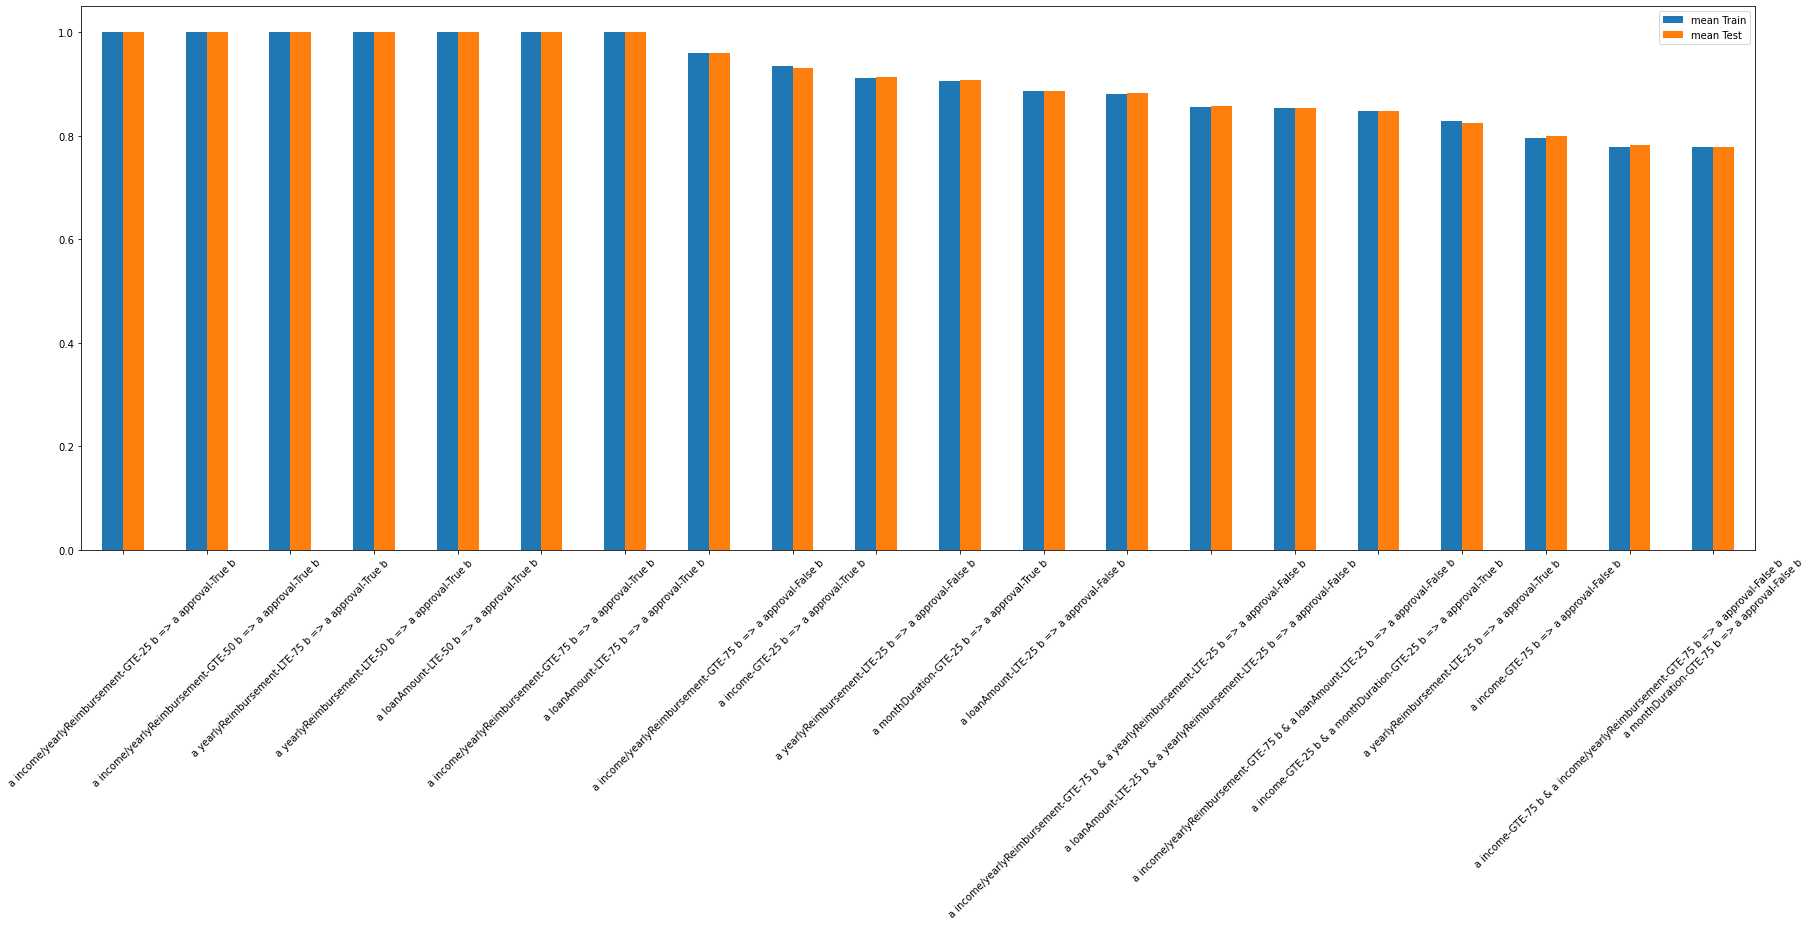

In [55]:
fig, _axs = plt.subplots(nrows=1, ncols=1, figsize=(30,10)) 
final_result.sort_values("mean Train", ascending=False).iloc[:20].plot(kind="bar", y=["mean Train", "mean Test"], ax=_axs, rot=45)

# Test

In [28]:
%%time 

i = 0
f = open(f"{root}index_{i}.tsv", "r")

lines = f.readlines()
train_index = np.array(list(map(int, lines[0].split(","))))
test_index = np.array(list(map(int, lines[1].split(","))))

f.close()

df = pd.read_csv("./../dfSave.csv")

success_train = {}
fail_train = {}
success_test = {}
fail_test = {}

cp = 0

for rule in rules_per_cv[i]:    
    success_train[str(rule)] = 0
    fail_train[str(rule)] = 0
    print(cp, " : ", rule)
    for j in train_index:
        if (rule.conclusion.predicate == "approval-True" and df.loc[j]["approval"]) or (rule.conclusion.predicate == "approval-False" and not df.loc[j]["approval"]):
            truth = True
            for atome_hyp in rule.hypotheses:
                truth = (df.loc[j][atome_hyp.predicate] == df.loc[j]["approval"] ) and truth
            if truth:
                success_train[str(rule)] += 1
            else:
                fail_train[str(rule)] += 1
            
    success_test[str(rule)] = 0 
    fail_test[str(rule)] = 0 
    for j in test_index:
        truth = True
        for atome_hyp in rule.hypotheses:
            truth = (df.loc[j][atome_hyp.predicate] == df.loc[j]["approval"] ) and truth
        if truth:
            success_test[str(rule)] += 1
        else:
            fail_test[str(rule)] += 1
    
    cp += 1

0  :  a creditScore-GTE-75 b & a monthDuration-GTE-50 b => a approval-False b
1  :  a creditScore-LTE-50 b & a yearlyReimbursement-LTE-25 b => a approval-False b
2  :  a creditScore-GTE-50 b & a monthDuration-GTE-25 b => a approval-True b


KeyboardInterrupt: 

### Tentative threads

In [13]:
def computeAccuracy(rules, df, acc_train, acc_test, index, cptShared):
    print(f"Process n°{index} : Launched")
    len_tot = len(rules)
    for cpt, rule in enumerate(rules):  
        tp_success_train = 0
        tp_fail_train = 0
        for j in train_index:
            if (rule.conclusion.predicate == "approval-True" and df.loc[j]["approval"]) or (rule.conclusion.predicate == "approval-False" and not df.loc[j]["approval"]):
                truth = True
                for atome_hyp in rule.hypotheses:
                    truth = (df.loc[j][atome_hyp.predicate] == df.loc[j]["approval"] ) and truth
                if truth:
                    tp_success_train += 1
                else:
                    tp_fail_train += 1
                    
        acc_train[str(rule)] = tp_success_train/(tp_fail_train+tp_success_train)

        tp_success_test = 0 
        tp_fail_test = 0 
        for j in test_index:
            truth = True
            for atome_hyp in rule.hypotheses:
                truth = (df.loc[j][atome_hyp.predicate] == df.loc[j]["approval"] ) and truth
            if truth:
                tp_success_test += 1
            else:
                tp_fail_test += 1
        
        acc_test[str(rule)] = tp_success_test/(tp_success_test+tp_fail_test)
        
        cptShared.value += 1
        if (cptShared.value%100 == 0):
            print(cptShared)
        
    print(f"Process n°{index} : Finished")

In [23]:
# %%time 

# import multiprocessing 
# import logging
# import threading
# import time

# i = 0
# f = open(f"{root}index_{i}.tsv", "r")

# lines = f.readlines()
# train_index = np.array(list(map(int, lines[0].split(","))))
# test_index = np.array(list(map(int, lines[1].split(","))))

# f.close()

# df = pd.read_csv("./../dfSave.csv")

# success_train = {}
# fail_train = {}
# success_test = {}
# fail_test = {}
 
# threads_to_create = multiprocessing.cpu_count()-4 
# threads = list()

# rules_list = list(rules)[:20]

# for index in range(threads_to_create):
#     x = threading.Thread(target=computeAccuracy, args=(rules_list[int(np.floor(index*len(rules_list)/threads_to_create)): int(np.floor((index+1)*len(rules_list)/threads_to_create))], df, success_train, fail_train, index))
#     threads.append(x)
#     x.start()
    
# for index, thread in enumerate(threads):
#     logging.info("Main    : before joining thread %d.", index)
#     thread.join()
#     logging.info("Main    : thread %d done", index)

In [22]:
%%time

from multiprocessing import Process, Manager
import multiprocessing

names = []
accuracy_train_CV = []
accuracy_test_CV = []

rules = rules_per_cv[0]

with Manager() as manager:
    
    i = 0
    f = open(f"{root}index_{i}.tsv", "r")

    lines = f.readlines()
    train_index = np.array(list(map(int, lines[0].split(","))))
    test_index = np.array(list(map(int, lines[1].split(","))))

    f.close()

    df = pd.read_csv("./../dfSave.csv")

    acc_train =  manager.dict()
    acc_test =  manager.dict()
    
    cpt_total = manager.Value("d",0)

    processes_to_create = multiprocessing.cpu_count()-3
    processes = list()

    rules_list = list(rules)[:12]

    for index in range(processes_to_create):
        x = Process(target=computeAccuracy, args=(rules_list[int(np.floor(index*len(rules_list)/processes_to_create)): int(np.floor((index+1)*len(rules_list)/processes_to_create))], df, acc_train, acc_test, index, cpt_total))
        processes.append(x)
        x.start()

    for index, process in enumerate(processes):
        process.join()
        
    accuracy_train_CV.append(acc_train.copy())
    accuracy_test_CV.append(acc_test.copy())
    
print(np.mean(list(accuracy_train_CV[0].values())))
print(np.mean(list(accuracy_test_CV[0].values())))

Process n°0 : Launched
Process n°1 : LaunchedProcess n°0 : Finished

Process n°2 : Launched
Process n°3 : Launched
Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched
Process n°7 : Launched
Process n°8 : Launched
Process n°9 : Launched
Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched
Process n°4 : Finished
Process n°3 : Finished
Process n°6 : FinishedProcess n°9 : Finished

Process n°11 : Finished
Process n°10 : Finished
Process n°8 : Finished
Process n°7 : FinishedProcess n°1 : Finished

Process n°2 : Finished
Process n°12 : Finished
Process n°5 : Finished
0.4923334235666435
0.38595228095438094
CPU times: user 250 ms, sys: 547 ms, total: 797 ms
Wall time: 1min 11s


In [62]:
tp = pd.DataFrame(columns=names, data=[accuracy_train, accuracy_test], index=["Train", "Test"]).T
tp

,Train,Test
a loanAmount-GTE-25 b => a approval-True b,0.262856,0.145377
a rate-GTE-25 b & a rate-LTE-75 b => a approval-True b,0.494680,0.108838
a rate-LTE-75 b & a yearlyReimbursement-LTE-25 b => a approval-True b,0.635043,0.321234
a income-GTE-25 b => a approval-False b,0.302400,0.438561
a monthDuration-GTE-75 b => a approval-False b,0.778825,0.688396
...,...,...
a income-GTE-75 b & a monthDuration-GTE-75 b => a approval-False b,0.615626,0.514010
a creditScore-LTE-75 b & a monthDuration-GTE-25 b => a approval-True b,0.682172,0.205076
a loanAmount-LTE-50 b & a yearlyReimbursement-GTE-75 b => a approval-False b,0.388528,0.306414
a creditScore-LTE-50 b & a income/yearlyReimbursement-GTE-50 b => a approval-False b,0.316629,0.357803


In [63]:
tp.to_csv("Save_results.csv")

In [2]:
pd.read_csv("Save_results.csv",index_col=0)

,Train,Test
a loanAmount-GTE-25 b => a approval-True b,0.262856,0.145377
a rate-GTE-25 b & a rate-LTE-75 b => a approval-True b,0.494680,0.108838
a rate-LTE-75 b & a yearlyReimbursement-LTE-25 b => a approval-True b,0.635043,0.321234
a income-GTE-25 b => a approval-False b,0.302400,0.438561
a monthDuration-GTE-75 b => a approval-False b,0.778825,0.688396
...,...,...
a income-GTE-75 b & a monthDuration-GTE-75 b => a approval-False b,0.615626,0.514010
a creditScore-LTE-75 b & a monthDuration-GTE-25 b => a approval-True b,0.682172,0.205076
a loanAmount-LTE-50 b & a yearlyReimbursement-GTE-75 b => a approval-False b,0.388528,0.306414
a creditScore-LTE-50 b & a income/yearlyReimbursement-GTE-50 b => a approval-False b,0.316629,0.357803


# 💀💀💀

In [105]:
for p in processes:
    p.kill()

### Tentative opti

In [84]:
%%time
i = 0
f = open(f"{root}index_{i}.tsv", "r")

lines = f.readlines()
train_index = np.array(list(map(int, lines[0].split(","))))
test_index = np.array(list(map(int, lines[1].split(","))))

f.close()

df = pd.read_csv("./../dfSave.csv")

rule = list(rules_per_cv[0])[0]

acc_train = {}
acc_test = {}

tp_success_train = 0
tp_fail_train = 0
for j in train_index:
    if (rule.conclusion.predicate == "approval-True" and df.loc[j]["approval"]) or (rule.conclusion.predicate == "approval-False" and not df.loc[j]["approval"]):
        truth = True
        for atome_hyp in rule.hypotheses:
            truth = (df.loc[j][atome_hyp.predicate] == df.loc[j]["approval"] ) and truth
        if truth:
            tp_success_train += 1
        else:
            tp_fail_train += 1
print(tp_success_train, tp_fail_train, len(df)-tp_fail_train-tp_success_train)
    
acc_train[str(rule)] = tp_success_train/(tp_fail_train+tp_success_train)
print(acc_train)

tp_success_test = 0 
tp_fail_test = 0 
for j in test_index:
    truth = True
    for atome_hyp in rule.hypotheses:
        truth = (df.loc[j][atome_hyp.predicate] == df.loc[j]["approval"] ) and truth
    if truth:
        tp_success_test += 1
    else:
        tp_fail_test += 1

acc_test[str(rule)] = tp_success_test/(tp_success_test+tp_fail_test)

24968 27036 47996
{'a creditScore-LTE-50 b & a income/yearlyReimbursement-GTE-75 b => a approval-False b': 0.480116914083532}
CPU times: user 50.4 s, sys: 31.2 ms, total: 50.5 s
Wall time: 50.5 s


In [86]:
%%time
i = 0
f = open(f"{root}index_{i}.tsv", "r")

lines = f.readlines()
train_index = np.array(list(map(int, lines[0].split(","))))
test_index = np.array(list(map(int, lines[1].split(","))))

f.close()

df = pd.read_csv("./../dfSave.csv")

rule = list(rules_per_cv[0])[0]
columns = [rule.hypotheses[k].predicate for k in range(len(rule.hypotheses))]
columns.append("approval")

acc_train = {}
acc_test = {}

res = pd.Series()

if (rule.conclusion.predicate == "approval-True"):
    res = df[columns].loc[train_index].apply(func=prediction_right, axis=1, truth=True).value_counts()
else :
    res = df[columns].loc[train_index].apply(func=prediction_right, axis=1, truth=False).value_counts()

acc_train[rule] = res[True] / (res[True]+res[False])

if (rule.conclusion.predicate == "approval-True"):
    res = df[columns].loc[test_index].apply(func=prediction_right, axis=1, truth=True).value_counts()
else :
    res = df[columns].loc[test_index].apply(func=prediction_right, axis=1, truth=False).value_counts()

acc_test[str(rule)] = res[True] / (res[True]+res[False])

<timed exec>:19: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


CPU times: user 1.55 s, sys: 15.6 ms, total: 1.56 s
Wall time: 1.56 s


In [39]:
t = [rule.hypotheses[k].predicate for k in range(len(rule.hypotheses))]
t.append("approval")
t

['creditScore-LTE-50', 'income/yearlyReimbursement-GTE-75', 'approval']

In [85]:
def prediction_right(X, truth):
    if X["approval"] !=  truth:
        return "Not an example"
    else :
        sum_X = sum(X)
        return sum_X == len(X) or sum_X == 0

In [12]:
t = pd.Series([100])